In [1]:
import pandas as pd
import numpy as np
import random

import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.base import clone
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import SGDRegressor, LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR


## Import Dataset

In [2]:
df = pd.read_csv('C:/Users/Gerardo/Documents/Projects/ds4a/datasets/current_final_datset.csv')
df.dtypes

Year                                       int64
State                                     object
Housing_Prices_Quarter                   float64
Community_Spending                       float64
Unexpected_Housing_Spending              float64
Govt_Direct_Expenditure                  float64
Property_Rights                          float64
Number_Interest_Groups                   float64
No_Discrimination_Laws                      bool
Private_Fair_Housing                        bool
Public_Fair_Housing                         bool
Urban_Fair_Housing                          bool
Banned_Discrimination_Public_Housing        bool
Banned_Discrimination_Private_Housing       bool
Legislation_Public_Housing                  bool
Rent_Control                                bool
State_Aid_Allowed                           bool
Federal_Aid_Allowed                         bool
Prohibit_Rent_Control                       bool
County                                    object
Metro               

## One Hot encode categorical data

In [3]:
cols_to_onehot = ['No_Discrimination_Laws','Private_Fair_Housing',
                  'Public_Fair_Housing','Urban_Fair_Housing',
                  'Banned_Discrimination_Public_Housing',
                  'Banned_Discrimination_Private_Housing',
                  'Legislation_Public_Housing','Rent_Control',
                  'State_Aid_Allowed','Federal_Aid_Allowed',
                  'Prohibit_Rent_Control','Metro']

x_onehot = {}
for c in cols_to_onehot:
    if df[c].dtypes == 'bool':
        onehot  = OneHotEncoder()
        onehot.fit(df[c].values.reshape(-1,1))
        x_onehot[c + '_implemented']=onehot.transform(df[c].values.reshape(-1,1)).toarray()[:,0]
        x_onehot[c + '_NOT_implemented']=onehot.transform(df[c].values.reshape(-1,1)).toarray()[:,0]

## Continuous Data - Exploration and Scaling

Quick investigation regarding the distributions of the variables

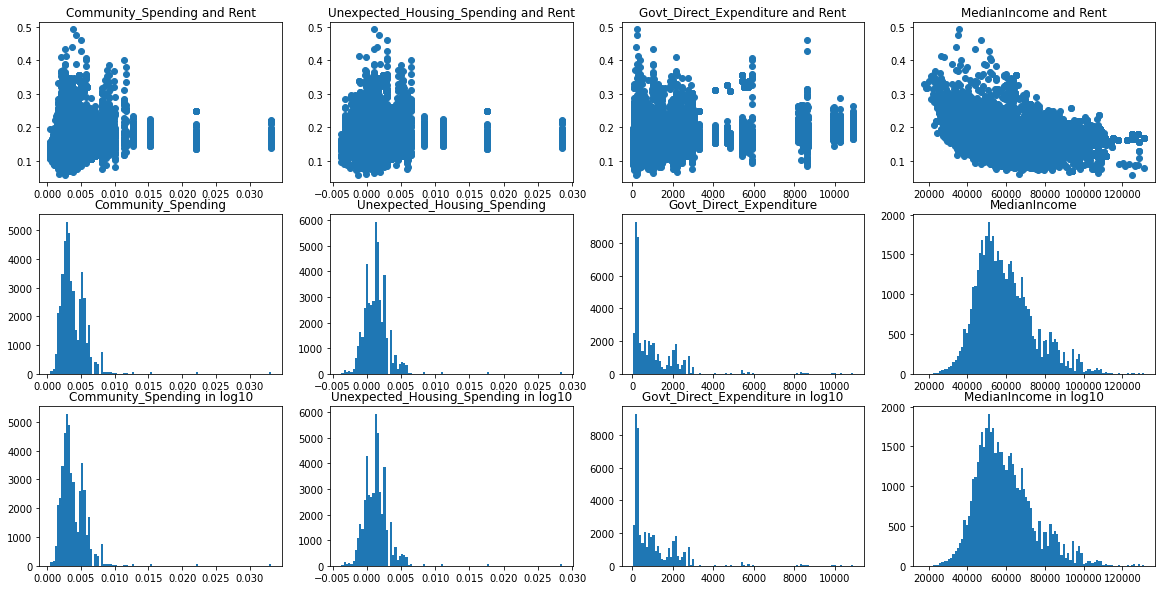

In [4]:
cols_to_scale = ['Community_Spending','Unexpected_Housing_Spending','Govt_Direct_Expenditure','MedianIncome']

_,ax = plt.subplots(nrows=3,ncols = len(cols_to_scale),figsize=(20,10))
for i,c in enumerate(cols_to_scale):
    ax[0][i].scatter(df[c],df['Income_Adjusted_Rent50'])
    ax[0][i].set_title(f'{c} and Rent')
    ax[1][i].hist(df[c],bins = 100)
    ax[1][i].set_title(f'{c}')
    ax[2][i].hist(df[c],bins = 100)
    ax[2][i].set_title(f'{c} in log10')

Looks like Median Income is somewhat gaussian which is good. Two other metrics, community_spending and unexpected_housing_spending, seem to have Gaussian-esque, so we will train on this. Govt_Direct_Expenditure has no shape, log or not, so we will stick with this. 

In [5]:
x_scaled = {}
for c in cols_to_scale:
    my_scaler = StandardScaler()
    my_scaler.fit(df[c].values.reshape(-1,1))
    x_scaled[c] = my_scaler.transform(df[c].values.reshape(-1,1)).flatten()

## Appending One hot encoded and scaled data

In [6]:
x_scaled.update(x_onehot)

In [7]:
y = df['Rent50']
X = pd.DataFrame(x_scaled)
X.sample(3)

,Community_Spending,Unexpected_Housing_Spending,Govt_Direct_Expenditure,MedianIncome,No_Discrimination_Laws_implemented,No_Discrimination_Laws_NOT_implemented,Private_Fair_Housing_implemented,Private_Fair_Housing_NOT_implemented,Public_Fair_Housing_implemented,Public_Fair_Housing_NOT_implemented,...,Rent_Control_implemented,Rent_Control_NOT_implemented,State_Aid_Allowed_implemented,State_Aid_Allowed_NOT_implemented,Federal_Aid_Allowed_implemented,Federal_Aid_Allowed_NOT_implemented,Prohibit_Rent_Control_implemented,Prohibit_Rent_Control_NOT_implemented,Metro_implemented,Metro_NOT_implemented
25099,-0.647233,-0.533744,-0.295893,0.875331,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
286,-0.407145,-0.537685,-0.436467,-0.832575,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
989,-0.892879,-1.052632,-0.648240,-1.167459,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0


## Modeling Time

In [8]:
polyfit = PolynomialFeatures(degree=2)
X_poly = polyfit.fit_transform(X)

In [9]:
my_minmaxer = MinMaxScaler()
#y = my_minmaxer.fit_transform(y.values.reshape(-1,1))

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X_poly,y,test_size = .3) #70% training
X_val, X_test, y_val,y_test = train_test_split(X_test,y_test,test_size = .5) #15% validation

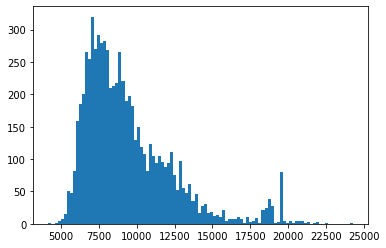

In [11]:
plt.hist(y_test,bins=100);

Unconstrained Linear Regression RMSE: 1548.0612215060653


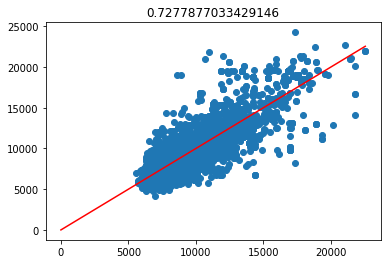

In [12]:
def My_LinReg(X_train,X_test,y_train,y_test):
    linreg = LinearRegression()
    linreg.fit(X_train,y_train)
    y_pred = linreg.predict(X_test)
    linreg_score = np.sqrt(mean_squared_error(y_test,y_pred))

    print(f'Unconstrained Linear Regression RMSE: {linreg_score}');
    plt.scatter(y_pred,y_test)
    plt.plot([0,y_pred.max()],[0,y_pred.max()],color='red');
    plt.title(r2_score(y_test,y_pred))
    return linreg
    
linreg = My_LinReg(X_train,X_test,y_train,y_test)



In [13]:
coefs = pd.DataFrame([[k,v] for k,v in zip(X.columns,linreg.coef_)],columns = ['Feature','Coefficient']).sort_values('Coefficient')
coefs

,Feature,Coefficient
5,No_Discrimination_Laws_NOT_implemented,-8.351726e+14
13,Banned_Discrimination_Public_Housing_NOT_imple...,-1.141464e+14
22,Federal_Aid_Allowed_implemented,-8.833750e+13
12,Banned_Discrimination_Public_Housing_implemented,-8.406340e+13
19,Rent_Control_NOT_implemented,-4.399058e+13
16,Legislation_Public_Housing_implemented,-2.960503e+13
21,State_Aid_Allowed_NOT_implemented,-2.201003e+13
23,Federal_Aid_Allowed_NOT_implemented,-1.843281e+13
17,Legislation_Public_Housing_NOT_implemented,-2.930746e+10
2,Govt_Direct_Expenditure,-3.375652e+03


SGD Regression RMSE: 1589.4759206300687


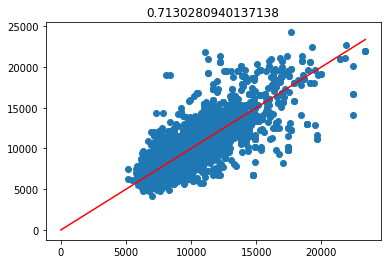

In [18]:
def my_SGD(X_train,X_test,y_train,y_test,lr,eta0):
    sgdreg = SGDRegressor(penalty= 'elasticnet',l1_ratio = .5,random_state= 42,learning_rate = lr,eta0 = eta0)
    sgdreg.fit(X_train,y_train)
    y_pred = sgdreg.predict(X_test)
    sgdreg_score = np.sqrt(mean_squared_error(y_test,y_pred))

    print(f'SGD Regression RMSE: {sgdreg_score}');
    plt.scatter(y_pred,y_test)
    plt.plot([0,y_pred.max()],[0,y_pred.max()],color='red');
    plt.title(r2_score(y_test,y_pred))
    
my_SGD(X_train,X_test,y_train,y_test,'constant',.000003)

## Implementation of Batch Linear Regression

In [19]:
def my_mini_batch(model,X_train,X_val,y_train,y_val,batch_size,iters):
    batch_indx = random.sample(range(len(X_train)),int(len(X_train)*batch_size / 100))
    
    pred_loss,val_loss = [],[]
    for i in range(iters):
        subX = X_train[batch_indx]
        subY = y_train.iloc[batch_indx]

        model.partial_fit(subX,subY)

            
        y_pred_train = model.predict(subX)
        pred_loss.append(np.sqrt(mean_squared_error(subY,y_pred_train)))
        
        y_pred_val = model.predict(X_val)
        val_loss.append(np.sqrt(mean_squared_error(y_val,y_pred_val)))
        
        if i % 100 == 0:
            print(f'Training loss: {pred_loss[i]}')
            print(f'Validation loss: {val_loss[i]}')
    
    plt.plot(range(iters),pred_loss,color ='red',label='Training Loss')
    plt.plot(range(iters),val_loss,color = 'blue',label = 'Validation Loss')
    plt.legend()
    return model

Training loss: 8706.47745912129
Validation loss: 8661.9373659936
Training loss: 2974.9993148973203
Validation loss: 2909.4036856920293
Training loss: 2485.5607955184855
Validation loss: 2426.7455684153424
Training loss: 2292.4265873618906
Validation loss: 2234.311854067642
Training loss: 2182.632077028962
Validation loss: 2123.815713142298
Training loss: 2110.2909430002314
Validation loss: 2051.0640770389346
Training loss: 2057.256808127497
Validation loss: 1998.1123649553308
Training loss: 2015.2717082939498
Validation loss: 1956.6084965794869
Training loss: 1980.318831869379
Validation loss: 1922.4135315938167
Training loss: 1950.2969865752418
Validation loss: 1893.324399233522
Training loss: 1924.0078874839767
Validation loss: 1868.066229159332
Training loss: 1900.7016827994382
Validation loss: 1845.8345720772709
Training loss: 1879.8664509072853
Validation loss: 1826.080226026185
Training loss: 1861.1267747787583
Validation loss: 1808.4034289002202
Training loss: 1844.1923237661956

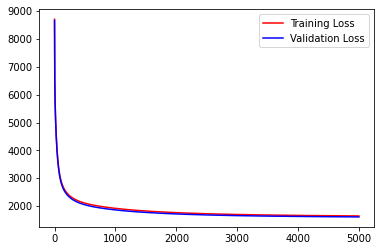

In [24]:
newsgd = SGDRegressor(penalty= 'l2',alpha = .0001,random_state= 42,learning_rate='constant',eta0=1E-7)
newsgd = my_mini_batch(newsgd,X_train,X_val,y_train,y_val,75,5000)


y_pred = newsgd.predict(X_test)
newsgd_score = np.sqrt(mean_squared_error(y_test,y_pred))

print(f'SGD Regression RMSE: {newsgd_score}')
print(r2_score(y_test,y_pred))

In [27]:
import pickle
#with open('sgd_model_220209.pkl','wb') as f:
#    pickle.dump(newsgd,f)

0.6913562367177746


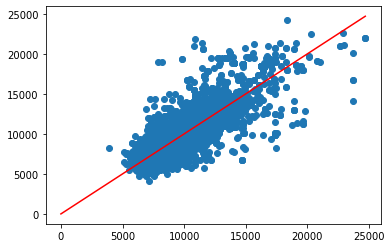

In [25]:
print(r2_score(y_test,y_pred))
plt.scatter(y_pred,y_test)
plt.plot([0, y_pred.max()],[0, y_pred.max()],color='red')

SGD Regression RMSE: 1550.7191650022833


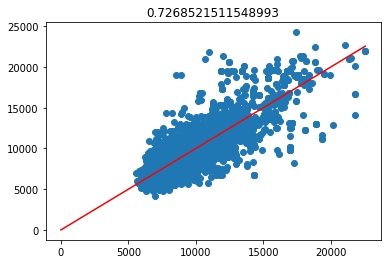

In [30]:
def My_Ridge(alpha,X_train,X_test,y_train,y_test):

    ridge_reg = Ridge(alpha = alpha)
    ridge_reg.fit(X_train,y_train)
    y_pred = ridge_reg.predict(X_test)
    ridge_reg_score = np.sqrt(mean_squared_error(y_test,y_pred))

    print(f'SGD Regression RMSE: {ridge_reg_score}');
    plt.scatter(y_pred,y_test)
    plt.plot([0,y_pred.max()],[0,y_pred.max()],color='red');
    plt.title(r2_score(y_test,y_pred))
    
My_Ridge(.9,X_train,X_test,y_train,y_test)

SGD Regression RMSE: 979.8815443088806


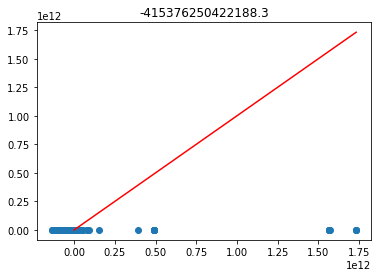

In [ ]:
def my_Forest(X_train,X_test,y_train,y_test):
    forest_reg = RandomForestRegressor()
    forest_reg.fit(X_train,y_train)
    y_preds = forest_reg.predict(X_test)

    forest_reg_score = np.sqrt(mean_squared_error(y_test,y_preds))
    print(f'SGD Regression RMSE: {forest_reg_score}');

    plt.scatter(y_pred,y_test)
    plt.plot([0,y_pred.max()],[0,y_pred.max()],color='red')
    plt.title(r2_score(y_test,y_pred))

my_Forest(X_train,X_test,y_train,y_test)